# Problem Statement
DeepSig Dataset: RadioML 2016.04C
A synthetic dataset, generated with GNU Radio, consisting of 11 modulations. This
is a variable-SNR dataset with moderate LO drift, light fading, and numerous
different labeled SNR increments for use in measuring performance across different
signal and noise power scenarios.

In [22]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
import scipy.integrate as it
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
import keras.models as models
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [15, 15]
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["KERAS_BACKEND"] = "tensorflow"  # Automatically runs on GPU if one detected
import random, sys, keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
Xd = cPickle.load(open("../input/rml2016/RML2016.10b.dat",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
lbl = np.array(lbl)
print(X.shape)
print(lbl.shape)

(1200000, 2, 128)
(1200000, 2)


In [5]:
print(Xd.keys())
print(len(Xd.keys()))

dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('PAM4', 18), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('8PSK', -18), ('PAM4', -6), ('WBFM', -18), ('BPSK', 8), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('AM-DSB', -18), ('QPSK', 8), ('PAM4', 14), ('WBFM', -8), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('8PSK', -10), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('WBFM', -14), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('QAM16', 8), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('WBFM', 10), ('BPSK', -20), ('PAM4', 4), ('GFSK', 10), ('QAM16', -6), ('QAM64', 4), ('PAM4', -20), ('8PSK', 10), ('QAM64', -10), (

In [6]:
keys_list = list(Xd.keys())
curr_item = Xd[keys_list[0]] 
print(len(curr_item[0]))
print(len(curr_item[0][0]))

2
128


In [7]:
print(Xd[('8PSK',0)].shape)

(6000, 2, 128)


In [8]:
print(X.shape)

(1200000, 2, 128)


In [9]:
Xd.clear()

## 2. Create Feature Space 
Every sample is presented using two vectors each of them has 128 elements.
You might try the raw features and you can make a battery of more features
such as
1. Raw time series as given (two channels)
2. First derivative in time (two channels)
3. Integral in time (two channels)
4. combinations of 1,2 and 3. (More channels)

In [ ]:
def getFeatureSpaces(data):
  feature_space = list()
  feature_space.clear()
  for i in tqdm(range(len(data))):
    I_signal = np.array(X[i][0])
    Q_signal = np.array(X[i][1])   
    diff_I = np.array(np.diff(X[i][0]))
    diff_Q = np.array(np.diff(X[i][1])) 
    int_I = it.cumtrapz(X[i][0],initial=0)
    int_Q = it.cumtrapz(X[i][1],initial=0) 
    feature_space.append([I_signal,Q_signal,diff_I,diff_Q,int_I,int_Q,np.add(diff_I,I_signal[1:]),np.add(diff_Q,Q_signal[1:])])
  return np.array(feature_space)

feature_space = getFeatureSpaces(X)

In [ ]:
len(feature_space)

In [ ]:
plt.figure()
plt.plot(range(0,128),feature_space[100000][0],label = "I Channel")
plt.plot(range(0,128),feature_space[100000][1],label = "Q Channel")
plt.plot(range(1,128),feature_space[100000][2],label = "Diff-I Channel")
plt.plot(range(1,128),feature_space[100000][3],label = "Diff-Q Channel")
plt.plot(range(0,128),feature_space[100000][4],label = "Integral-I Channel")
plt.plot(range(0,128),feature_space[100000][5],label = "Integral-Q Channel")
plt.plot(range(1,128),feature_space[100000][6],label = "Combination-I Channel")
plt.plot(range(1,128),feature_space[100000][7],label = "Combination-Q Channel")
plt.legend(loc='lower left')

In [10]:
data = list()  #1200000 example col[0] -> I-Signal col[1] -> Q-Signal col[2] -> SNR

for i in range(len(X)): 
  int_I = it.cumtrapz(X[i][0],initial=0)
  int_Q = it.cumtrapz(X[i][1],initial=0) 
  data.append([int_I,int_Q])
  
data = np.array(data)

In [11]:
print(data.shape)

(1200000, 2, 128)


In [13]:
X = data

## 3. Supervised Learning Step
a. Split the data into 70% for training/validation and 30% for testing.

b. Use 5% of the training and validation dataset for validation.

c. CNN Model
i. You will apply the CNN architecture shown below. The
number of channels in the input layer might be changed as you
apply different types of features.

d. Build two models, the vanilla RNN and LSTM as classifiers and train
them.

e. Apply hyperparameter tuning on the learning rate of the
abovementioned models on the validation dataset

In [14]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
    
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [15]:
X_train, x_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size=0.05, random_state=100,stratify=Y_train)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [16]:
in_shp = list(X_train.shape[1:])

print(X_train.shape, in_shp)
classes = mods

(798000, 2, 128) [2, 128]


In [17]:
 print(in_shp)

[2, 128]


In [18]:
#Defining some varibales (Epochs ,Dropout rate , batch size)
dr = 0.005
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size

In [48]:
model_c = keras.models.Sequential()
model_c.add(Reshape(in_shp+[1], input_shape=in_shp))
# no padding for the height and add padding to width (2 more columns)
model_c.add(ZeroPadding2D((0, 2)))
model_c.add(Conv2D(256, (1, 3), padding='valid', activation='relu', name="conv1",kernel_initializer='glorot_uniform'))
model_c.add(Dropout(dr))
model_c.add(ZeroPadding2D((0, 2)))
model_c.add(Conv2D(80, (2, 3), padding='valid', activation='relu', name="conv2",
                  kernel_initializer='glorot_uniform'))
model_c.add(Dropout(dr))
# The coming layer is dense to we need to flatten our inputs
model_c.add(Flatten())
model_c.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model_c.add(Dropout(dr))
model_c.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model_c.add(Activation('softmax'))
model_c.add(Reshape([len(classes)]))
model_c.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_c.summary()

filepath = 'convmodrecnets_CNN2_c_0.5.wts.h5'
history_c=model_c.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(x_val, y_val),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model_c.load_weights(filepath)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 134, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 132, 80)       

In [49]:
score = model_c.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

[1.1345914602279663, 0.528688907623291]


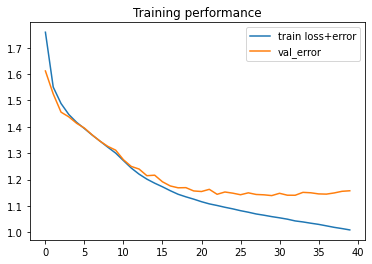

In [50]:
plt.figure()
plt.title('Training performance')
plt.plot(history_c.epoch, history_c.history['loss'], label='train loss+error')
plt.plot(history_c.epoch, history_c.history['val_loss'], label='val_error')
plt.legend()

In [51]:
from sklearn.metrics import accuracy_score
from pandas import DataFrame as df
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  print("Average = ")
  print(sum(y_axis) / len(y_axis))
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  return y_pred


In [52]:
test_SNRs=[]
for i in range(len(test_idx)):
  test_SNRs.append(lbl[test_idx[i]][1].astype(int))
print(test_SNRs)
y_pred_c = model_c.predict(X_test)

[8, -20, -20, 8, 8, -20, -20, -20, 8, -20, 8, 8, -20, 8, -20, -20, -20, -20, 8, -20, 8, 8, -20, -20, 8, 8, -20, 8, -20, 8, -20, 8, 8, -20, 8, -20, 8, -20, -20, 8, -20, 8, 8, -20, 8, -20, -20, 8, 8, -20, -20, -20, 8, 8, -20, -20, 8, 8, 8, 8, -20, -20, 8, -20, 8, -20, 8, 8, -20, 8, -20, -20, 8, 8, -20, -20, -20, 8, -20, -20, -20, 8, -20, 8, -20, -20, -20, -20, 8, 8, 8, 8, 8, -20, 8, -20, -20, -20, -20, -20, 8, 8, 8, -20, -20, 8, -20, 8, -20, -20, 8, 8, 8, 8, -20, 8, 8, -20, 8, 8, 8, 8, 8, 8, -20, -20, -20, -20, -20, 8, -20, -20, -20, 8, -20, 8, -20, 8, 8, 8, -20, 8, -20, 8, -20, 8, 8, -20, 8, 8, -20, -20, -20, 8, 8, 8, -20, 8, 8, -20, 8, -20, -20, -20, -20, -20, 8, 8, -20, -20, -20, -20, -20, -20, -20, 8, 8, 8, 8, 8, 8, 8, 8, -20, 8, 8, -20, 8, 8, -20, 8, -20, 8, 8, 8, 8, -20, -20, 8, 8, -20, -20, -20, -20, 8, 8, -20, 8, 8, -20, -20, -20, -20, -20, -20, -20, -20, -20, 8, 8, 8, -20, -20, -20, 8, 8, 8, -20, -20, 8, -20, -20, -20, 8, -20, 8, 8, -20, 8, -20, 8, -20, 8, -20, 8, -20, -20, -20,

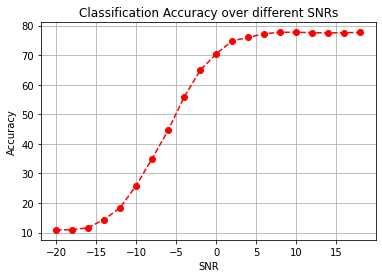

In [53]:
plot_results(y_pred_c, Y_test, test_SNRs)

In [54]:
print_results(y_pred_c, Y_test, test_SNRs)

Average = 
0.5285677351052303


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.88,10.93,11.64,14.4,18.36,25.88,35.0,44.62,55.88,64.9,70.47,74.88,76.0,77.28,77.76,77.77,77.63,77.53,77.63,77.69


In [56]:
print(y_pred_c)

[[1.32892266e-01 3.03748863e-19 2.67505789e-06 ... 6.77201606e-05
  8.66910279e-01 1.61105487e-15]
 [1.24216929e-01 1.11119509e-01 1.11497946e-01 ... 2.85213832e-02
  1.21403590e-01 1.29485875e-01]
 [1.76380187e-01 7.17794942e-03 1.09384567e-01 ... 1.21997841e-01
  1.92032531e-01 1.46378484e-02]
 ...
 [1.07409902e-01 1.08039294e-19 1.97855206e-06 ... 1.59381926e-02
  8.63178551e-01 1.91650588e-16]
 [4.29694295e-01 3.77239260e-19 4.04569664e-06 ... 1.62141025e-02
  5.34083784e-01 2.82744442e-16]
 [6.22476591e-03 6.85915700e-17 1.43461818e-06 ... 1.05998117e-06
  9.93769944e-01 1.72534228e-13]]


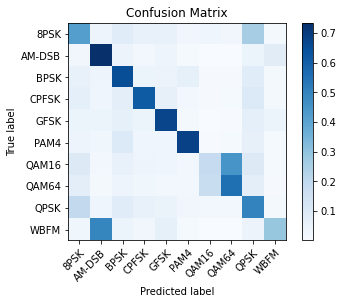

In [57]:
show_y_pred_c=plot_confusion_matrix(Y_test, y_pred_c, mods)

In [58]:
print(show_y_pred_c)

[8 9 8 ... 8 8 8]


## RNN & LSTM

In [39]:
model = keras.Sequential()
model.add(layers.SimpleRNN(128, input_shape=in_shp))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 34,698
Trainable params: 34,442
Non-trainable params: 256
_________________________________________________________________
None


In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [41]:
history = model.fit(
    X_train, Y_train, validation_data=(x_val, y_val), batch_size=64, epochs=50,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ]
)

2022-06-24 18:58:17.204909: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 817152000 exceeds 10% of free system memory.


Epoch 1/50
12469/12469 [==============================] - 61s 5ms/step - loss: 1.9234 - accuracy: 0.2490 - val_loss: 1.8246 - val_accuracy: 0.2755
Epoch 2/50
12469/12469 [==============================] - 61s 5ms/step - loss: 1.7917 - accuracy: 0.2860 - val_loss: 1.7727 - val_accuracy: 0.2980
Epoch 3/50
12469/12469 [==============================] - 61s 5ms/step - loss: 1.7361 - accuracy: 0.3026 - val_loss: 1.7065 - val_accuracy: 0.3175
Epoch 4/50
12469/12469 [==============================] - 60s 5ms/step - loss: 1.6947 - accuracy: 0.3177 - val_loss: 1.6807 - val_accuracy: 0.3282
Epoch 5/50
12469/12469 [==============================] - 63s 5ms/step - loss: 1.6663 - accuracy: 0.3277 - val_loss: 1.6366 - val_accuracy: 0.3420
Epoch 6/50
12469/12469 [==============================] - 62s 5ms/step - loss: 1.6420 - accuracy: 0.3377 - val_loss: 1.6204 - val_accuracy: 0.3436
Epoch 7/50
12469/12469 [==============================] - 61s 5ms/step - loss: 1.6204 - accuracy: 0.3461 - val_loss: 1

In [42]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

[1.4155762195587158, 0.42383334040641785]


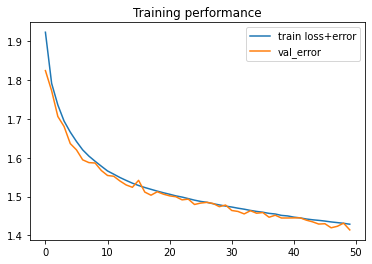

In [43]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [44]:
# test_SNRs=[]
# for i in range(len(test_idx)):
#   test_SNRs.append(lbl[test_idx[i]][1].astype(int))
# print(test_SNRs)
y_pred = model.predict(X_test)

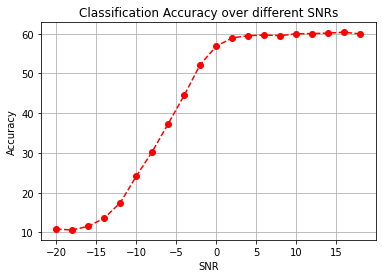

In [45]:
plot_results(y_pred, Y_test, test_SNRs)

In [46]:
print_results(y_pred, Y_test, test_SNRs)

Average = 
0.4237446441275683


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.82,10.63,11.51,13.58,17.41,24.08,30.28,37.34,44.51,52.24,56.86,58.96,59.52,59.67,59.53,60.0,60.05,60.18,60.38,59.96


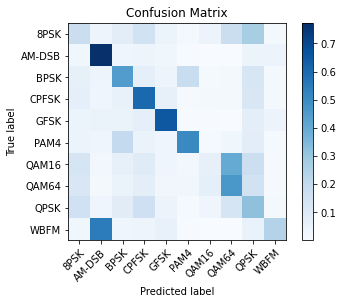

In [47]:
show_y_pred=plot_confusion_matrix(Y_test, y_pred, mods)

In [24]:
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(128, return_sequences=True, name='lstm-1', input_shape = in_shp))
LSTM_Model.add(LSTM(64, name='lstm-2'))
LSTM_Model.add(Dense(10, activation='softmax'))
LSTM_Model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
LSTM_Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm-1 (LSTM)                (None, 2, 128)            131584    
_________________________________________________________________
lstm-2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 181,642
Trainable params: 181,642
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = LSTM_Model.fit(
    X_train, Y_train, validation_data=(x_val, y_val), batch_size=64, epochs=100,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ]
)

2022-06-24 17:53:18.885086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 817152000 exceeds 10% of free system memory.
2022-06-24 17:53:19.775599: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 817152000 exceeds 10% of free system memory.
2022-06-24 17:53:20.426124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-24 17:53:23.836209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12469/12469 [==============================] - 66s 5ms/step - loss: 1.7136 - accuracy: 0.3055 - val_loss: 1.5914 - val_accuracy: 0.3421
Epoch 2/100
12469/12469 [==============================] - 61s 5ms/step - loss: 1.5350 - accuracy: 0.3618 - val_loss: 1.4889 - val_accuracy: 0.3819
Epoch 3/100
12469/12469 [==============================] - 59s 5ms/step - loss: 1.4563 - accuracy: 0.3933 - val_loss: 1.4300 - val_accuracy: 0.4028
Epoch 4/100
12469/12469 [==============================] - 59s 5ms/step - loss: 1.4009 - accuracy: 0.4173 - val_loss: 1.3807 - val_accuracy: 0.4289
Epoch 5/100
12469/12469 [==============================] - 59s 5ms/step - loss: 1.3557 - accuracy: 0.4372 - val_loss: 1.3493 - val_accuracy: 0.4447
Epoch 6/100
12469/12469 [==============================] - 59s 5ms/step - loss: 1.3177 - accuracy: 0.4540 - val_loss: 1.3125 - val_accuracy: 0.4528
Epoch 7/100
12469/12469 [==============================] - 60s 5ms/step - loss: 1.2879 - accuracy: 0.4667 - val_loss: 1.2930

In [26]:
score = LSTM_Model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

2022-06-24 18:46:02.850276: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 368640000 exceeds 10% of free system memory.


[1.1572754383087158, 0.5260888934135437]


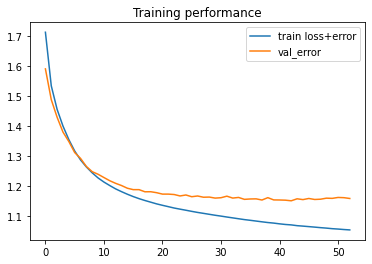

In [27]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [29]:
# test_SNRs=[]
# for i in range(len(test_idx)):
#   test_SNRs.append(lbl[test_idx[i]][1].astype(int))
# print(test_SNRs)
y_pred = LSTM_Model.predict(X_test)

2022-06-24 18:54:20.175981: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 368640000 exceeds 10% of free system memory.


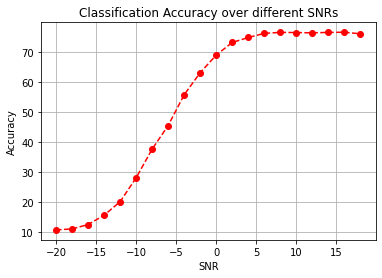

In [34]:
plot_results(y_pred, Y_test, test_SNRs)

In [35]:
print_results(y_pred, Y_test, test_SNRs)

Average = 
0.5259681148887989


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.74,11.08,12.54,15.62,20.15,28.09,37.67,45.51,55.76,63.12,68.97,73.17,74.82,76.19,76.53,76.46,76.37,76.51,76.57,76.05


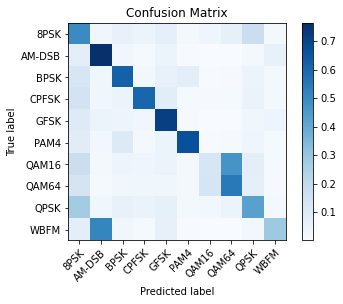

In [37]:
show_y_pred=plot_confusion_matrix(Y_test, y_pred, mods)